In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import numpy as np
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from tqdm import tqdm
import codecs
import tensorflow
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM,Dropout,Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Matt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
## Loading the data
df = pd.read_csv('data/train.csv',encoding='utf-8')
holdout = pd.read_csv('data/test.csv',encoding='utf-8')
df.head(7)
holdout.shape

(3263, 4)

# Data Preprocessing
 1. Remove URL 
 2. Remove emojis 
 3. Remove Contractions 
 4. Remove Punctuations
 5. Remove Stopwords

In [65]:
def remove_URL(text):
    urls = re.compile(r'https?://\S+|www\.\S+')
    text_without_https =  urls.sub(r'',text)
    url = re.compile(r'http?://\S+|www\.\S+')
    return url.sub(r'',text_without_https)


#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#remove contractions
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"thx"   : "thanks"
}

def remove_contractions(text):
    temp = text.split()
    final_text =''
    for wrd in temp:
        if wrd.lower() in contractions:
            replaced_word = contractions[wrd.lower()] + ' '
        else:
            replaced_word = wrd + ' '
        final_text  = final_text + replaced_word
    return final_text.strip()



#remove punctuation
import string
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(remove_URL)
df['text']=df['text'].apply(remove_emoji)
df['text']=df['text'].apply(remove_contractions)
df['text']=df['text'].apply(remove_punct)


holdout['text']=holdout['text'].apply(remove_URL)
holdout['text']=holdout['text'].apply(remove_emoji)
holdout['text']=holdout['text'].apply(remove_contractions)
holdout['text']=holdout['text'].apply(remove_punct)

In [66]:
train_tweets = list()
holdout_tweets = list()
lines =df['text'].values.tolist()
for line in tqdm(lines):
  token = word_tokenize(line)
  token = [word.lower() for word in token]
  table = str.maketrans('','',string.punctuation)
  stripped = [word.translate(table) for word in token]
  words = [word for word in stripped if word.isalpha()]
  stopped_words = set(stopwords.words('english'))
  final_token = [w for w in words if w not in stopped_words]
  train_tweets.append(final_token)




lines =holdout['text'].values.tolist()
for line in tqdm(lines):
  token = word_tokenize(line)
  token = [word.lower() for word in token]
  table = str.maketrans('','',string.punctuation)
  stripped = [word.translate(table) for word in token]
  words = [word for word in stripped if word.isalpha()]
  stopped_words = set(stopwords.words('english'))
  final_token = [w for w in words if w not in stopped_words]
  holdout_tweets.append(final_token)
    
    
print(train_tweets[:3])
print("---------")
print(holdout_tweets[:3])
print(holdout.shape)

100%|██████████| 3263/3263 [00:01<00:00, 2236.32it/s]

[['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['residents', 'asked', 'shelter', 'place', 'notified', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']]
---------
[['happened', 'terrible', 'car', 'crash'], ['heard', 'earthquake', 'different', 'cities', 'stay', 'safe', 'everyone'], ['forest', 'fire', 'spot', 'pond', 'geese', 'fleeing', 'across', 'street', 'save']]
(3263, 4)


100%|██████████| 7613/7613 [00:00<00:00, 636131.09it/s]


Text(0.5, 0, 'Number of words')

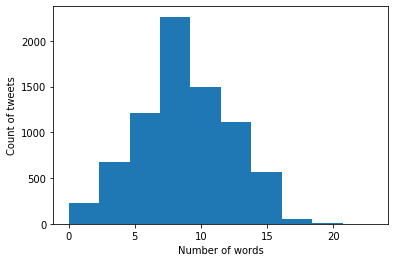

In [67]:
#checking distrubtion of length of tweets
%matplotlib inline

len_list=[]
for i in tqdm(tweets):
    len_list.append(len(i))

plt.hist(len_list, density=False, bins=10)  
plt.ylabel('Count of tweets')
plt.xlabel('Number of words')

Most tweets have less than 20 words.
Next step is to create a dictionary of words with n dimensions which will be used in the model. Will be using GloVe embedding with 300 dimensions which can be downloaded from https://nlp.stanford.edu/projects/glove/

In [10]:
embeddings_index_glove = {}
f = codecs.open('embeddings/glove.840B.300d.txt', encoding='utf-8')

for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
f.close()

In [13]:
#spot checking the embedding index dictionary
embeddings_index_glove['hurricane']

array([-0.43674  , -0.10333  ,  0.33635  ,  0.051283 , -0.19348  ,
       -0.20316  , -0.4466   ,  1.0433   ,  0.26677  ,  1.7239   ,
       -0.28369  , -0.26205  , -0.45438  , -0.30005  , -0.61656  ,
        0.62768  , -0.23625  ,  0.91878  ,  0.065177 , -0.63918  ,
        0.12668  ,  0.17995  , -0.19695  ,  0.19099  , -0.10736  ,
       -0.50168  , -0.55079  , -0.19555  ,  0.1151   , -0.017492 ,
        0.091201 , -0.78987  , -0.43777  ,  0.15285  ,  0.053872 ,
        0.020404 , -0.18169  ,  0.072808 , -0.28677  ,  0.13125  ,
       -0.11851  ,  0.077099 ,  0.36826  , -0.30647  ,  0.061576 ,
       -0.39104  , -0.082649 , -0.37517  ,  0.19079  , -0.020282 ,
       -0.30688  ,  0.12898  ,  0.20518  ,  0.42767  , -1.0231   ,
        0.068287 ,  0.15214  , -0.12757  , -0.020682 ,  0.045102 ,
       -0.32932  ,  0.39246  , -0.062813 ,  0.20911  , -0.20522  ,
        0.079021 , -0.12221  ,  0.61051  , -0.25953  ,  0.39264  ,
        0.2195   ,  0.31411  , -0.308    ,  0.38777  ,  0.4542

In [68]:
MAX_LEN_OF_TWEET = 20
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(train_tweets)
train_sequences=tokenizer_obj.texts_to_sequences(train_tweets)
train_tweet_pad = pad_sequences(train_sequences,maxlen=MAX_LEN_OF_TWEET)
word_index = tokenizer_obj.word_index
is_disaster = np.array(df['target'])


num_validation_sample=int(VALIDATION_SPLIT*train_tweet_pad.shape[0])
x_val_pad = train_tweet_pad[:num_validation_sample]
y_val = is_disaster[:num_validation_sample]
x_train_pad = train_tweet_pad[num_validation_sample:] 
y_train = is_disaster[num_validation_sample:]

num_test_sample=int(TEST_SPLIT*x_train_pad.shape[0])
x_test_pad = train_tweet_pad[:num_test_sample]
y_test = is_disaster[:num_test_sample]
x_train_pad = x_train_pad[num_test_sample:] 
y_train = y_train[num_test_sample:]



holdout_sequences=tokenizer_obj.texts_to_sequences(holdout_tweets)
holdout_tweet_pad = pad_sequences(holdout_sequences,maxlen=MAX_LEN_OF_TWEET)
x_holdout = holdout_tweet_pad

print(x_test_pad.shape)
print(x_train_pad.shape)
print(x_val_pad.shape)
print(x_holdout.shape)

(1218, 20)
(4873, 20)
(1522, 20)
(3263, 20)


## Creating an Embedding Matrix


In [69]:
num_words =len(word_index)+1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))
for word, i in word_index.items():
  if i>num_words:
    continue
  embedding_vector = embeddings_index_glove.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## Training 

In [70]:
model = Sequential()
embedding_layer = Embedding(num_words,EMBEDDING_DIM,input_length=MAX_LEN_OF_TWEET, weights=[embedding_matrix],trainable=False)

model.add(embedding_layer)
model.add(Dropout(0.3))

model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print('Summary of built model ..')
print(model.summary())

Summary of built model ..
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 300)           4828200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 20, 32)            9632      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 20, 128)           49664     
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_18 (Bidirectio

Assign the model.fit() method to a variable, which will store the Training, Validation Loss and Accuracy for each epoch. 


In [81]:
history = model.fit(x_train_pad,y_train,batch_size=128,epochs=20,validation_data=(x_val_pad,y_val),verbose=2)

Epoch 1/15
39/39 - 25s - loss: 0.2421 - accuracy: 0.9015 - val_loss: 0.5803 - val_accuracy: 0.8049
Epoch 2/15
39/39 - 29s - loss: 0.2340 - accuracy: 0.9070 - val_loss: 0.5635 - val_accuracy: 0.7898
Epoch 3/15
39/39 - 28s - loss: 0.2352 - accuracy: 0.9007 - val_loss: 0.5824 - val_accuracy: 0.8009
Epoch 4/15
39/39 - 22s - loss: 0.2310 - accuracy: 0.9070 - val_loss: 0.5837 - val_accuracy: 0.7884
Epoch 5/15
39/39 - 28s - loss: 0.2432 - accuracy: 0.9019 - val_loss: 0.6106 - val_accuracy: 0.7852
Epoch 6/15
39/39 - 25s - loss: 0.2338 - accuracy: 0.9079 - val_loss: 0.6143 - val_accuracy: 0.7858
Epoch 7/15
39/39 - 24s - loss: 0.2152 - accuracy: 0.9124 - val_loss: 0.5987 - val_accuracy: 0.7825
Epoch 8/15
39/39 - 20s - loss: 0.2657 - accuracy: 0.8988 - val_loss: 0.5701 - val_accuracy: 0.7898
Epoch 9/15
39/39 - 18s - loss: 0.2246 - accuracy: 0.9120 - val_loss: 0.6254 - val_accuracy: 0.7930
Epoch 10/15
39/39 - 18s - loss: 0.2258 - accuracy: 0.9136 - val_loss: 0.6009 - val_accuracy: 0.8003
Epoch 11/

## Evaluating the Model on Test Set

**Score** is the evaluation of the loss function for a given input.

**Accuracy** How accurate your model's prediction is compared to the true data.

In [82]:
loss_score,accuracy_score = model.evaluate(x_test_pad,y_test,batch_size=128)
print('Test Loss score ',loss_score)
print('Test Accuracy score ',accuracy_score)

10/10 [==============================] - 1s 122ms/step - loss: 0.5603 - accuracy: 0.8095
Test Loss score  0.5603271126747131
Test Accuracy score  0.8095238208770752


## Testing the Model on Sample data


In [78]:
test_sample_1= 'hurricane in chennai'
test_sample_2= 'beware world ablaze sierra leone'
test_sample_3 = 'wild fire happening in bangalore '

test_samples = [test_sample_1,test_sample_2,test_sample_3]
test_sample_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_sample_tokens_pad = pad_sequences(test_sample_tokens,maxlen=20)

#predict
model.predict(x=test_sample_tokens_pad)

array([[0.7129875 ],
       [0.13017455],
       [0.9987523 ]], dtype=float32)

In [79]:
(model.predict(x_holdout)>0.5).astype(int).shape
sample_submission.shape
x_holdout.shape

(3263, 20)

In [80]:
#8. generating submission file  
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission['target']=(model.predict(x_holdout)>0.5).astype(int)
sample_submission.to_csv('submission0407_LSTM_v2.csv',index=False)